In [1]:
import getpass
import os
from langchain_community.utilities import SQLDatabase
from sqlalchemy import create_engine
import pandas as pd
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages
from langchain_core.tools import tool
from langchain_core.prompts import ChatPromptTemplate
from langchain_community.tools.sql_database.tool import QuerySQLDatabaseTool
from langchain_core.messages import SystemMessage, HumanMessage, ToolMessage
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from langgraph.graph import MessagesState
from typing_extensions import Literal


try:
    # load environment variables from .env file (requires `python-dotenv`)
    from dotenv import load_dotenv
    load_dotenv()
except ImportError:
    pass

os.environ["LANGSMITH_TRACING"] = "true"
if "LANGSMITH_API_KEY" not in os.environ:
    os.environ["LANGSMITH_API_KEY"] = getpass.getpass(
        prompt="Enter your LangSmith API key (optional): "
    )
if "LANGSMITH_PROJECT" not in os.environ:
    os.environ["LANGSMITH_PROJECT"] = getpass.getpass(
        prompt='Enter your LangSmith Project Name (default = "default"): '
    )
    if not os.environ.get("LANGSMITH_PROJECT"):
        os.environ["LANGSMITH_PROJECT"] = "default"
if "OPENAI_API_KEY" not in os.environ:
    os.environ["OPENAI_API_KEY"] = getpass.getpass(
        prompt="Enter your OpenAI API key (required if using OpenAI): "
    )

# Create a SQLAlchemy engine
engine = create_engine('sqlite:///experiment_data.db')

# Load the experiment_data.csv into the database before initializing SQLDatabase
df = pd.read_csv('/Users/yixin/Projects/lang/smart_ds/experiment_data.csv')
df.to_sql('experiment_data', con=engine, if_exists='replace', index=False)

# Initialize the SQLDatabase with the engine
db = SQLDatabase(engine)

# Initialize Language model
from langchain.chat_models import init_chat_model
llm = init_chat_model("gpt-4o-mini", model_provider="openai")

# Define tools
@tool
def generate_and_execute_sql(question):
    """
    Given an input human question in English, create a syntactically correct sqlite query to
    run to help find the answer
    """

    # Annotations must have the type and can optionally include a default value and description (in that order).
    question: Annotated[str, ..., "Question"]

    system_message = """
    Given an input question, create a syntactically correct {dialect} query to
    run to help find the answer. Unless the user specifies in his question a
    specific number of examples they wish to obtain, always limit your query to
    at most {top_k} results. You can order the results by a relevant column to
    return the most interesting examples in the database.

    Never query for all the columns from a specific table, only ask for a the
    few relevant columns given the question.

    Pay attention to use only the column names that you can see in the schema
    description. Be careful to not query for columns that do not exist. Also,
    pay attention to which column is in which table.

    Only use the following tables:
    {table_info}
    """

    user_prompt = "Question: {input}"

    query_prompt_template = ChatPromptTemplate(
        [("system", system_message), ("user", user_prompt)]
    )

    class QueryOutput(TypedDict):
        """Generated SQL query."""
        query: Annotated[str, ..., "Syntactically valid SQL query."]

    prompt = query_prompt_template.invoke(
        {
            "dialect": db.dialect,
            "top_k": 100,
            "table_info": db.get_table_info(),
            "input": question,
        }
    )
    structured_llm = llm.with_structured_output(QueryOutput)
    query = structured_llm.invoke(prompt)
    execute_query_tool = QuerySQLDatabaseTool(db=db)
    return execute_query_tool.invoke(query)

# Augment the LLM with tools
tools = [generate_and_execute_sql]
tools_by_name = {tool.name: tool for tool in tools}
llm_with_tools = llm.bind_tools(tools)

# Define Node
class State(TypedDict):
    messages: Annotated[list, add_messages]
    query: str
    result: str
    answer: str

def tool_node(state: State):
    """Performs the tool call"""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}

def llm_call(state: State):
    """LLM decides whether to call a tool or not"""

    return {
        "messages": 
            llm_with_tools.invoke(
                [
                    SystemMessage(
                        content="You are a helpful assistant tasked with performing arithmetic on a set of inputs."
                    )
                ]
                + state["messages"]
            )        
    }

# Conditional edge function to route to the tool node or end based upon whether the LLM made a tool call
def should_continue(state: MessagesState) -> Literal["environment", END]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""

    messages = state["messages"]
    last_message = messages[-1]
    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "Action"
    # Otherwise, we stop (reply to the user)
    return END

In [9]:
execute_query_tool = QuerySQLDatabaseTool(db=db)
result = execute_query_tool.invoke("select * from experiment_data")
# Assuming result is a list of tuples, where the first tuple contains column names
column_names = result[0] if result else []
data_rows = result[1:] if result else []
(column_names, data_rows)

('[',
 '(1, 0.2054792820232115, 0), (2, 0.2723859937913791, 0), (3, 0.2624978915182918, 0), (4, 0.2498531597900225, 1), (5, 0.2248228539213531, 1), (6, 0.2540644526065223, 1), (7, 0.2178004209429416, 1), (8, 0.1979183871492253, 0), (9, 0.1560251558485576, 1), (10, 0.1453296547949505, 0), (11, 0.1463412401985573, 0), (12, 0.3463476698418115, 1), (13, 0.2718147587020391, 1), (14, 0.265596105682039, 1), (15, 0.2388232556029091, 1), (16, 0.2400999125387863, 0), (17, 0.2962062540986674, 1), (18, 0.1943973488886741, 1), (19, 0.1622544219526337, 0), (20, 0.2423521460361604, 1), (21, 0.2397104496609722, 1), (22, 0.3046374363570699, 1), (23, 0.2651074978673247, 1), (24, 0.2643392409413033, 1), (25, 0.23091933093584, 0), (26, 0.2863034717131146, 1), (27, 0.1933100738265228, 1), (28, 0.1730112460663322, 0), (29, 0.2072349978975101, 0), (30, 0.2890202579309981, 1), (31, 0.3491830963667772, 1), (32, 0.3339014501907602, 1), (33, 0.3633743855687934, 1), (34, 0.2066289394438615, 1), (35, 0.35849792978

In [10]:
def compute_treatment_effect(df: pd.DataFrame, metric_col='metric', experiment_group_col='experiment_group'):
    from statsmodels.formula.api import ols
    # Define the formula for the linear regression
    formula = f"{metric_col} ~ C({experiment_group_col})"
    # Fit the model
    model = ols(formula, data=df).fit()

    # Extract the treatment effect and p-value
    treatment_effect = model.params[1]  # Coefficient for the treatment group
    p_value = model.pvalues[1]  # P-value for the treatment group
    return float(treatment_effect), float(p_value)

compute_treatment_effect(df, metric_col='conversion_rate')

/var/folders/z3/cbyd2nws5s73q2r3gszpxz8c0000gn/T/ipykernel_62974/1248700241.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  treatment_effect = model.params[1]  # Coefficient for the treatment group
/var/folders/z3/cbyd2nws5s73q2r3gszpxz8c0000gn/T/ipykernel_62974/1248700241.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = model.pvalues[1]  # P-value for the treatment group


(0.06908631692516938, 7.894195541419475e-09)

In [ ]:
@tool
def compute_variance(df: pd.DataFrame, metric_col='metric'):
    """
    Given a pandas dataframe and a column name, compute the variance of that column
    """

    # Annotations must have the type and can optionally include a default value and description (in that order).
    df: Annotated[pd.DataFrame, ..., "Input Data"]
    df: Annotated[pd.DataFrame, ..., "Input Data"]
    return float(df[metric_col].var())


compute_variance(df, 'conversion_rate')


AttributeError: 'str' object has no attribute 'parent_run_id'

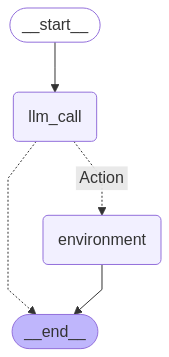

In [6]:
# Build workflow
agent_builder = StateGraph(State)
# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_edge(START, "llm_call")

agent_builder.add_node("environment", tool_node)
agent_builder.add_edge("llm_call", "environment")

agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        # Name returned by should_continue : Name of next node to visit
        "Action": "environment",
        END: END,
    },
)


agent = agent_builder.compile()

display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [8]:
def stream_graph_updates(user_input: str):
    for event in agent.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value)

stream_graph_updates("what is number of female users in treatment group")

Assistant: {'messages': AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_58aKksb6kio2I0BN2PggU4Zq', 'function': {'arguments': '{"question":"What is the number of female users in the treatment group?"}', 'name': 'generate_and_execute_sql'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 28, 'prompt_tokens': 89, 'total_tokens': 117, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_129a36352a', 'id': 'chatcmpl-BUgO7efWPPfztZm82ZjJnUvfYCb9x', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--b1f62371-b8b8-466e-afa5-ed6411d5bdfc-0', tool_calls=[{'name': 'generate_and_execute_sql', 'args': {'question': 'What is the number of female users in the treatment group?'}, 'id':